The previous notebook showed that it is possible for an MLP to learn decently the acoustic wave equation for one timestep. The goal of this notebook is to see if the first 10 timesteps can be approximated with an MLP. In the beginning the source term is not negligible, the last time step will act as the boudary loss for the PINN

In this model, the minibatch gradient descent is used instead of the full gradient descent simply because of computational power, the number of samples used for the training doesn't fit on the GPU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [2]:
# Pytorch Model Name
model_name = 'Moseley_PINN_1000.pt'

# Load Salvus data
path = "../NoCrack/Simple_Homogeneous_Moseley/Event0000/output.h5"
hf = h5py.File(path, 'r')

In [3]:
timestep = 36

df_test = pd.DataFrame()
df_test['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
df_test['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
df_test['T'] = timestep
df_test['True'] = hf['volume']['phi'][timestep][:,0].mean(axis=1)

In [4]:
max_timestep = 40

df_train = pd.DataFrame()

for ts in range(0,max_timestep,4):
    df_ts = pd.DataFrame()
    df_ts['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
    df_ts['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
    df_ts['T'] = ts
    df_ts['True'] = hf['volume']['phi'][ts][:,0].mean(axis=1)

    df_train = pd.concat((df_train,df_ts),axis=0)
df_train = df_train.reset_index(drop=True)

In [5]:
# Scaling, optional
from sklearn.preprocessing import MinMaxScaler

scaling = True
if scaling:
    scaler = MinMaxScaler()
    df_train[['X','Y','T','True']] = scaler.fit_transform(df_train[['X','Y','T','True']])

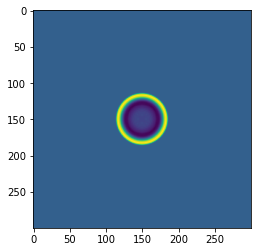

In [6]:
# Pivot Table to reorder the data
df_show = df_test.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False)

# Plot
plt.imshow(df_show.values)

In [7]:
df_train

,X,Y,T,True
0,0.464883,0.000000,0.0,0.313437
1,0.464883,0.003344,0.0,0.313437
2,0.464883,0.006689,0.0,0.313437
3,0.464883,0.010033,0.0,0.313437
4,0.464883,0.013378,0.0,0.313437
...,...,...,...,...
899995,0.986622,0.498328,1.0,0.313437
899996,0.989967,0.498328,1.0,0.313437
899997,0.993311,0.498328,1.0,0.313437
899998,0.996656,0.498328,1.0,0.313437


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model import *

In [9]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
class dataset(Dataset):
    def __init__(self, inputs, outputs):
        super(Dataset, self).__init__()

        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return self.inputs.shape[0]
        
    def __getitem__(self, index):

        # X 
        X = self.inputs[index, :]

        y = self.outputs[index]
        return X, y

In [11]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch):
    
    model = model.to(device)

    train_dataset = dataset(X_train,y_train)

    trainloader = DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=0)

    tot_loss = []

    for i in range(epoch):
        model.train()

        epoch_loss = 0

        for X, true in trainloader:

            x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
            y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
            t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)

            true = torch.tensor(true).float().to(device)

            optimizer.zero_grad()

            preds = model(torch.cat([x, y, t], dim=1))

            loss = loss_fn(preds,true)

            loss.backward()
            optimizer.step()

            epoch_loss += loss

        tot_loss.append(epoch_loss)

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e' % (i,epoch_loss))

    return model, tot_loss

In [12]:
def plots(df_data):
    # Compute error :
    df_data['Error'] = df_data['Preds']-df_data['True']

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(df_data.pivot_table(values='Preds',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(df_data.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(df_data.pivot_table(values='Error',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [13]:
model = Model(in_size=3)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_train.loc[:,['X','Y','T']].values
y_train = df_train.loc[:,['True']].values

In [15]:
epoch = 1000
model_train, loss_train = train(model,X_train,y_train,loss_fn,optimizer,epoch)

C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

In [48]:
# Save model
PATH = model_name

torch.save(model_train.state_dict(), PATH)

In [15]:
def prediction(model,X_test,y_test,device):

    model = model.to(device)
    x = torch.tensor(X_test[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_test[:, 1:2], requires_grad=True).float().to(device)
    t = torch.tensor(X_test[:, 2:3], requires_grad=True).float().to(device)

    true = torch.tensor(y_test).float().to(device)

    model.eval()
    with torch.no_grad():

        preds = model(torch.cat([x, y, t], dim=1))

    preds = preds.detach().cpu().numpy()
    return preds

In [11]:
df_test[['X','Y','T','True']] = scaler.transform(df_test[['X','Y','T','True']])

X_test = df_test.loc[:,['X','Y','T']].values
y_test = df_test.loc[:,['True']].values

In [12]:
df_test

,X,Y,T,True
0,0.464883,0.000000,1.0,0.313437
1,0.464883,0.003344,1.0,0.313437
2,0.464883,0.006689,1.0,0.313437
3,0.464883,0.010033,1.0,0.313437
4,0.464883,0.013378,1.0,0.313437
...,...,...,...,...
89995,0.986622,0.498328,1.0,0.313437
89996,0.989967,0.498328,1.0,0.313437
89997,0.993311,0.498328,1.0,0.313437
89998,0.996656,0.498328,1.0,0.313437


In [13]:
# Load model
PATH = model_name

model_test = Model()
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
  (tanh): Tanh()
)

In [18]:
preds = prediction(model_test,X_test,y_test,device)

In [19]:
df_test['Preds'] = preds

In [20]:
df_test

,X,Y,T,True,Preds
0,0.464883,0.000000,1.0,0.313437,0.723143
1,0.464883,0.003344,1.0,0.313437,0.728128
2,0.464883,0.006689,1.0,0.313437,0.733077
3,0.464883,0.010033,1.0,0.313437,0.737991
4,0.464883,0.013378,1.0,0.313437,0.742870
...,...,...,...,...,...
89995,0.986622,0.498328,1.0,0.313437,0.801578
89996,0.989967,0.498328,1.0,0.313437,0.803117
89997,0.993311,0.498328,1.0,0.313437,0.804657
89998,0.996656,0.498328,1.0,0.313437,0.806195


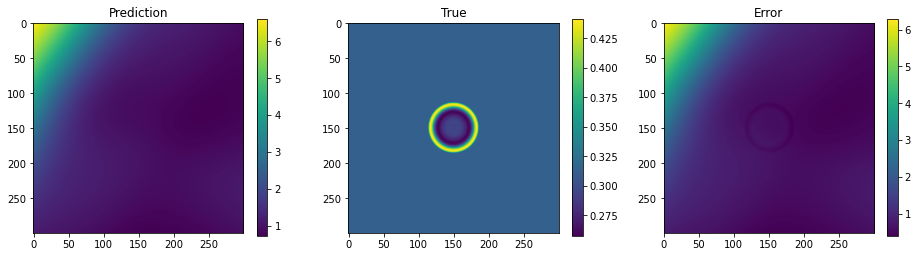

In [23]:
plots(df_test)